# Kernel Recursive Least Squares (KRLS) & Kernel Least Mean Squares

Example: Time series prediction

In [23]:
%matplotlib inline

import sys
import os
helpers_path = os.path.abspath('../')
if helpers_path not in sys.path:
    sys.path.append(helpers_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel
from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from data.datasets import load_dodd1
from sklearn.utils import shuffle

In [5]:
kernel = Kernel(3.73)
step_size = 0.09
reg_coeff = 0.03
threshold = 0.6
rls_threshold = 0.4
num_experiments = 20
num_data = 3000
D = 100
# Experiment
mse_KLMS = np.zeros(num_data)
mse_KNLMS = np.zeros(num_data)
mse_KRLS = np.zeros(num_data)
mse_KLMS_RFF = np.zeros(num_data)
mse_KNLMS_RFF = np.zeros(num_data)
mse_KRLS_RFF = np.zeros(num_data)

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for i in tqdm(range(num_experiments)):
    u,d,d_true = load_dodd1(num_data)
#     u,d,d_true = shuffle(u,d,d_true)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
    
    err_KLMS,_,_ = KLMS(u,d,kernel,step_size,threshold)
    mse_KLMS += (np.square((d_true - d) + err_KLMS))/num_experiments
    
    err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,reg_coeff,threshold)
    mse_KNLMS += (np.square((d_true - d) + err_KNLMS))/num_experiments

    err_KRLS,_,_ = KRLS(u,d,kernel,rls_threshold)
    mse_KRLS += (np.square((d_true - d) + err_KRLS))/num_experiments    

    err_KLMS_RFF,_ = KLMS_RFF.train(h,d,np.zeros((D,1)))
    mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

    err_KNLMS_RFF,_ = KNLMS_RFF.train(h,d,np.zeros((D,1)))
    mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

    err_KRLS_RFF,_,P = KRLS_RFF.train(h,d,np.zeros((D,1)),KRLS_RFF.P)
    mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments  

amse_KLMS = np.convolve(mse_KLMS,np.ones(20)/20,'valid')
amse_KNLMS = np.convolve(mse_KNLMS,np.ones(20)/20,'valid')
amse_KRLS = np.convolve(mse_KRLS,np.ones(20)/20,'valid')
amse_KLMS_RFF = np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid')
amse_KNLMS_RFF = np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid')
amse_KRLS_RFF= np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid')

100%|███████████████████████████████████████████| 20/20 [01:24<00:00,  4.22s/it]


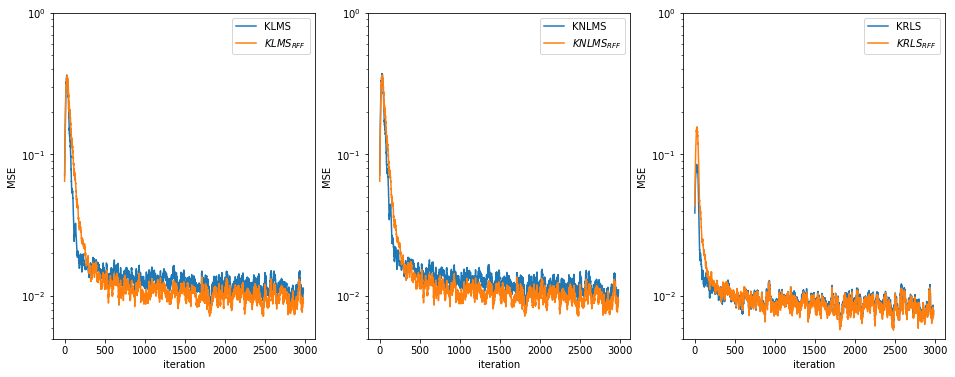

In [6]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.semilogy(range(len(amse_KLMS)),amse_KLMS, label='KLMS')
plt.semilogy(range(len(amse_KLMS_RFF)),amse_KLMS_RFF, label='$KLMS_{RFF}$')
plt.ylim([0.005,1e0])
plt.legend()
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1, 3, 2)
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS, label='KNLMS')
plt.semilogy(range(len(amse_KNLMS_RFF)),amse_KNLMS_RFF, label='$KNLMS_{RFF}$')
plt.ylim([0.005,1e0])
plt.legend()
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1, 3, 3)
plt.semilogy(range(len(amse_KRLS)),amse_KRLS, label='KRLS')
plt.semilogy(range(len(amse_KRLS_RFF)),amse_KRLS_RFF, label='$KRLS_{RFF}$')
plt.legend()
plt.ylim([0.005,1e0])
# plt.xlim([0,3000])
plt.legend()
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.show()

# Impact of dictionary sizes

In [15]:
num_experiments = 25
# Experiment
kernel = Kernel(3.73)
D = [25,50,100]
kernel = Kernel(3.73)
step_size = 0.09
reg_coeff = 1e-4
num_experiments = 25
num_data = 3000
beta = 0.999
mse_KLMS_RFF_smooth = []
mse_KNLMS_RFF_smooth = []
mse_KRLS_RFF_smooth = []
for i in range(len(D)):
    mse_KLMS_RFF = np.zeros(num_data)
    mse_KNLMS_RFF = np.zeros(num_data)
    mse_KRLS_RFF = np.zeros(num_data)
    KLMS_RFF = klms_rff(step_size,D[i])
    KNLMS_RFF = knlms_rff(step_size,reg_coeff,D[i])
    KRLS_RFF = krls_rff(D[i],beta=beta)    
    for j in tqdm(range(num_experiments)):
    #     print('experiment',i+1)
        u,d,d_true = load_dodd1(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(loc=0, scale=1.0, size=(2,D[i]))
        b = np.random.uniform(0,2*np.pi,D[i]).reshape(D[i],1)
        h = np.sqrt(2/D[i]) * np.cos(W.T @ u.T + b)

        err_KLMS_RFF,_ = KLMS_RFF.train(h,d,np.zeros((D[i],1)))
        mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

        err_KNLMS_RFF,_ = KNLMS_RFF.train(h,d,np.zeros((D[i],1)))
        mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

        err_KRLS_RFF,_,_ = KRLS_RFF.train(h,d,np.zeros((D[i],1)),KRLS_RFF.P)
        mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments     

    mse_KLMS_RFF_smooth.append(np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid'))
    mse_KNLMS_RFF_smooth.append(np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid'))
    mse_KRLS_RFF_smooth.append(np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid'))

100%|███████████████████████████████████████████| 25/25 [00:06<00:00,  4.15it/s]


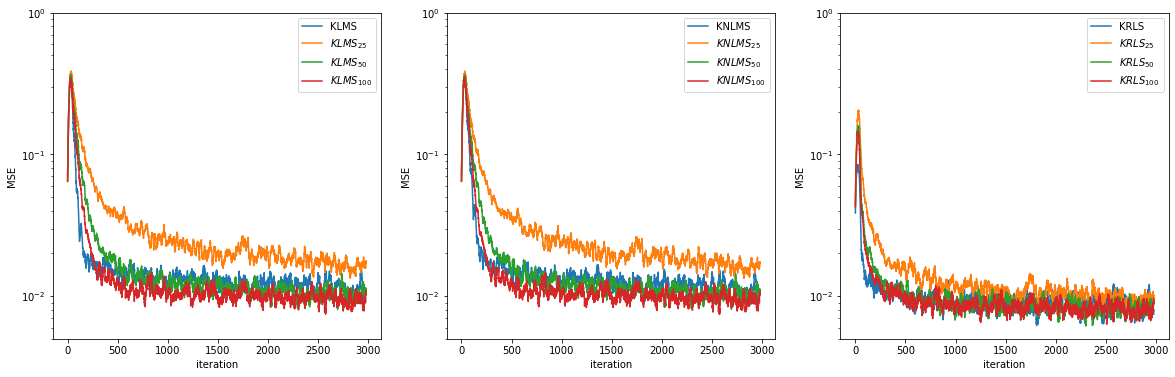

In [16]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1, 3, 1)
plt.semilogy(range(len(amse_KLMS)),amse_KLMS, label='KLMS')
for i in range(len(D)):
    plt.semilogy(range(len(mse_KLMS_RFF_smooth[i])),mse_KLMS_RFF_smooth[i], label="$KLMS_{" + str(D[i])+ "}$")
plt.legend()
plt.ylim([0.005,1e0])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1, 3, 2)
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS, label='KNLMS')
for i in range(len(D)):
    plt.semilogy(range(len(mse_KNLMS_RFF_smooth[i])),mse_KNLMS_RFF_smooth[i], label="$KNLMS_{" + str(D[i])+"}$")
plt.legend()
plt.ylim([0.005,1e0])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1, 3, 3)
plt.semilogy(range(len(amse_KRLS)),amse_KRLS, label='KRLS')
for i in range(len(D)):
    plt.semilogy(range(len(mse_KRLS_RFF_smooth[i])),mse_KRLS_RFF_smooth[i], label="$KRLS_{" + str(D[i])+"}$")
plt.legend()
plt.ylim([0.005,1e0])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.show()

# Impact of Gaussian widths

In [27]:
num_experiments = 25
# Experiment
sigmas = [1.5,3.73,4.5]
step_size = 0.09
reg_coeff = 0.03
D = 100

mse_KLMS_smooth = []
mse_KNLMS_smooth = []
mse_KRLS_smooth = []
mse_KLMS_RFF_smooth = []
mse_KNLMS_RFF_smooth = []
mse_KRLS_RFF_smooth = []

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for s in range(len(sigmas)):
    
    kernel = Kernel(sigmas[s])
    
    mse_KLMS = np.zeros(num_data)
    mse_KNLMS = np.zeros(num_data)    
    mse_KRLS = np.zeros(num_data)    
    mse_KLMS_RFF = np.zeros(num_data)
    mse_KNLMS_RFF = np.zeros(num_data)
    mse_KRLS_RFF = np.zeros(num_data)
    
    for j in tqdm(range(num_experiments)):
    #     print('experiment',i+1)
        u,d,d_true = load_dodd1(num_data)
        
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
        if s==1:
            err_KLMS,_,_ = KLMS(u,d,kernel,step_size,0.5)
            mse_KLMS += (np.square((d_true - d) + err_KLMS))/num_experiments

            err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,reg_coeff,0.5)
            mse_KNLMS += (np.square((d_true - d) + err_KNLMS))/num_experiments

            err_KRLS,_,_ = KRLS(u,d,kernel,0.5)
            mse_KRLS += (np.square((d_true - d) + err_KRLS))/num_experiments    

        err_KLMS_RFF,_ = KLMS_RFF.train(h,d,np.zeros((D,1)))
        mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

        err_KNLMS_RFF,_ = KNLMS_RFF.train(h,d,np.zeros((D,1)))
        mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

        err_KRLS_RFF,_,_ = KRLS_RFF.train(h,d,np.zeros((D,1)),KRLS_RFF.P)
        mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments     
        
    mse_KLMS_smooth.append(np.convolve(mse_KLMS,np.ones(20)/20,'valid'))
    mse_KNLMS_smooth.append(np.convolve(mse_KNLMS,np.ones(20)/20,'valid'))
    mse_KRLS_smooth.append(np.convolve(mse_KRLS,np.ones(20)/20,'valid'))
    mse_KLMS_RFF_smooth.append(np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid'))
    mse_KNLMS_RFF_smooth.append(np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid'))    
    mse_KRLS_RFF_smooth.append(np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid'))

100%|███████████████████████████████████████████| 25/25 [00:06<00:00,  4.16it/s]


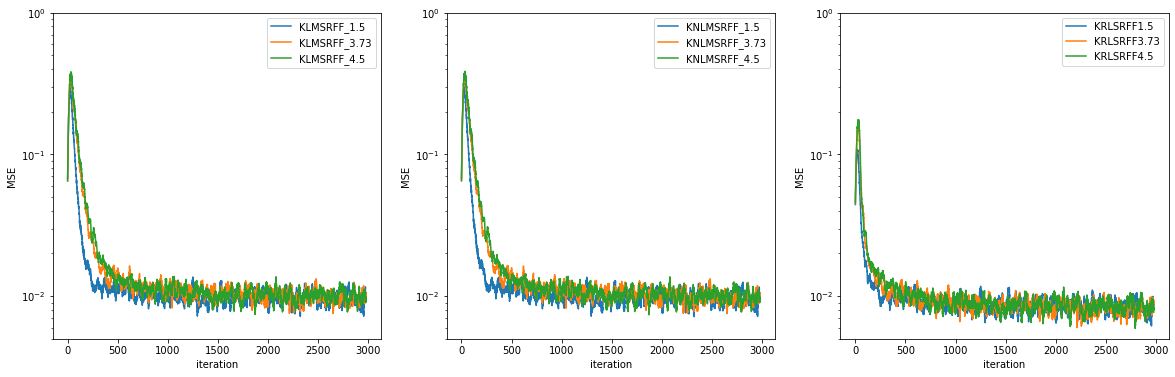

In [28]:
plt.figure(figsize=(2*10, 6))

plt.subplot(1, 3, 1)
for s in range(len(sigmas)):
#     plt.semilogy(range(len(mse_KLMS_smooth[s])),mse_KLMS_smooth[s], label='KLMS_' + str(sigmas[s]))  
    plt.semilogy(range(len(mse_KLMS_RFF_smooth[s])),mse_KLMS_RFF_smooth[s], label='KLMSRFF_' + str(sigmas[s]))
plt.ylabel("MSE")
plt.xlabel("iteration")    
plt.legend()
plt.ylim([0.005,1e0])
plt.subplot(1, 3, 2)
for s in range(len(sigmas)):
#     plt.semilogy(range(len(mse_KNLMS_smooth[s])),mse_KNLMS_smooth[s], label='KNLMS_' + str(sigmas[s]))  
    plt.semilogy(range(len(mse_KNLMS_RFF_smooth[s])),mse_KNLMS_RFF_smooth[s], label='KNLMSRFF_' + str(sigmas[s]))    
plt.ylabel("MSE")
plt.xlabel("iteration")    
plt.legend()
plt.ylim([0.005,1e0])
plt.subplot(1, 3, 3)
for s in range(len(sigmas)):
#     plt.semilogy(range(len(mse_KRLS_smooth[s])),mse_KRLS_smooth[s], label='KRLS_' + str(sigmas[s]))
    plt.semilogy(range(len(mse_KRLS_RFF_smooth[s])),mse_KRLS_RFF_smooth[s], label='KRLSRFF' + str(sigmas[s]))
plt.legend()
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.ylim([0.005,1e0])
# plt.xlim([0,3000])

plt.show()

In [31]:
b = [10,20,30,40,50]
a = [1,2,3,4,5]
a,b = shuffle(a,b)

In [32]:
a

[3, 1, 2, 5, 4]

In [33]:
b

[30, 10, 20, 50, 40]